In [1]:
import warnings
warnings.filterwarnings('ignore')import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime, timedelta

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
df_train = pd.read_csv("train_all.csv")
df_train.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name
0,2021-05-01 00:00:01.761000+00:00,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,51.94,...,25,0.328947,0.003045,3.25000,1,5,682,Slazenger,604,T-Shirt
1,2021-05-01 00:00:01.761000+00:00,3941815,0,157306,901280145,595758968,36888320,65612791,59.99,49.99,...,7,0.777778,0.000744,0.00000,0,0,381,Ltb,2949,Polo Yaka T-shirt
2,2021-05-01 00:00:01.761000+00:00,3941815,0,163856,901280144,595758968,36888399,65613254,49.90,49.90,...,3,0.200000,0.000633,0.00000,0,0,381,Ltb,2949,Polo Yaka T-shirt
3,2021-05-01 00:00:01.761000+00:00,3941815,0,163,901280149,595758968,36313798,64622938,129.95,59.97,...,0,0.000000,0.000545,4.47619,1,5,121,Pierre Cardin,604,T-Shirt
4,2021-05-01 00:00:02.742000+00:00,15996105,1,968,901279297,595758987,96930601,161408176,89.99,71.99,...,0,0.000000,0.002828,4.50000,2,5,40,TRENDYOLMİLLA,1182,Elbise


In [3]:
df_train.shape

(10702717, 31)

In [4]:
df_user = pd.read_csv("data/user_demographics.csv")
df_user.head()

,user_id,birth_date,membership_date,gender
0,22013146,NaN,2019-05-09 11:11:17.413000+00:00,Bay
1,49707264,NaN,2020-12-19 18:32:16.240000+00:00,Bay
2,48146878,NaN,2020-11-28 12:26:46.870000+00:00,Bay
3,53528681,NaN,2021-02-01 13:16:24.117000+00:00,Bay
4,17523184,NaN,2018-09-30 22:07:07.623000+00:00,Bay


In [5]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706439 entries, 0 to 706438
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          706439 non-null  int64 
 1   birth_date       437712 non-null  object
 2   membership_date  706439 non-null  object
 3   gender           706439 non-null  object
dtypes: int64(1), object(3)
memory usage: 21.6+ MB


In [10]:
from datetime import datetime, timezone

now = datetime.now(timezone.utc)

In [11]:
now

datetime.datetime(2022, 4, 11, 19, 23, 11, 136613, tzinfo=datetime.timezone.utc)

In [12]:
df_user['new_tenure'] = now - pd.to_datetime(df_user['membership_date'], errors='coerce')

In [16]:
df_user['tenure'] = df_user['new_tenure'].apply(lambda x: int(x[:x.find("days")]))

In [17]:
df_user

,user_id,birth_date,membership_date,gender,new_tenure,new_tenure2,tenure
0,22013146,NaN,2019-05-09 11:11:17.413000+00:00,Bay,1068 days 08:11:53.723613,1068 days 08:11:53.72,1068
1,49707264,NaN,2020-12-19 18:32:16.240000+00:00,Bay,478 days 00:50:54.896613,478 days 00:50:54.89,478
2,48146878,NaN,2020-11-28 12:26:46.870000+00:00,Bay,499 days 06:56:24.266613,499 days 06:56:24.26,499
3,53528681,NaN,2021-02-01 13:16:24.117000+00:00,Bay,434 days 06:06:47.019613,434 days 06:06:47.01,434
4,17523184,NaN,2018-09-30 22:07:07.623000+00:00,Bay,1288 days 21:16:03.513613,1288 days 21:16:03.51,1288
...,...,...,...,...,...,...,...
706434,21515712,1999-09-09 00:00:00+00:00,2019-04-09 21:49:18.960000+00:00,kvkktalepsilindi,1097 days 21:33:52.176613,1097 days 21:33:52.17,1097
706435,11486481,1999-09-09 00:00:00+00:00,2015-10-15 18:18:18.780000+00:00,kvkktalepsilindi,2370 days 01:04:52.356613,2370 days 01:04:52.35,2370
706436,17880994,1999-09-09 00:00:00+00:00,2018-10-31 10:46:45.920000+00:00,kvkktalepsilindi,1258 days 08:36:25.216613,1258 days 08:36:25.21,1258
706437,22586852,1999-09-09 00:00:00+00:00,2019-06-14 11:34:38.457000+00:00,kvkktalepsilindi,1032 days 07:48:32.679613,1032 days 07:48:32.67,1032


In [18]:
drop_cols = ["new_tenure", "new_tenure2", "birth_date", "membership_date"]
df_user.drop(drop_cols, axis=1, inplace=True)

In [19]:
df_user.head()

,user_id,gender,tenure
0,22013146,Bay,1068
1,49707264,Bay,478
2,48146878,Bay,499
3,53528681,Bay,434
4,17523184,Bay,1288


In [20]:
df = df_train.merge(df_user, on="user_id", how="left")

In [23]:
train_0 = df[df.is_returned == 0]
train_1 = df[df.is_returned == 1]

In [24]:
#numeric olan değerleri z_score a veriyorum
z_score = zscore(train_0[['original_price', 'discounted_price', 'coupon_discount', "returnRate",
   "total_claim", "unresolved_claim", "unresolved_accepted_claim", "unresolvedclaim_percentage",
    "defective_returnRate", "review_rates_mean", "review_rates_min", "review_rates_max", "tenure"]])

In [25]:
train_0.shape

(9341481, 33)

In [26]:
abs_zscore = abs(z_score)
train_0 = train_0[(abs_zscore < 3).all(axis=1)]

In [27]:
train_0.shape

(7927702, 33)

In [28]:
train_zscore = pd.concat([train_0, train_1])

In [29]:
train_zscore.shape

(9288938, 33)

In [30]:
train_zscore["is_saved_card_trx"] = train_zscore["is_saved_card_trx"].replace({True: 1, False: 0})

In [31]:
#df["total_discount"] = df["original_price"] - df["discounted_price"]
train_zscore["discount_ratio"] = train_zscore["discounted_price"] / train_zscore["original_price"]
train_zscore["discount_with_promotion"] = ((train_zscore["coupon_discount"] * -1) + (train_zscore["promotion_award_value"])).fillna(0) / 100

In [32]:
df = train_zscore

In [33]:
df["has_coupon"] = df["coupon_id"].notna().astype(int)
df["used_promo"] = df["promotion_name"].notna().astype(int)

In [36]:
df["gender"] = df["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": -1, "kvkktalepsilindi": -2})

In [37]:
df.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,brand_id,brand_name,category_id,category_name,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo
0,2021-05-01 00:00:01.761000+00:00,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,51.94,...,682,Slazenger,604,T-Shirt,1,4022,0.650063,0.35,0,1
3,2021-05-01 00:00:01.761000+00:00,3941815,0,163,901280149,595758968,36313798,64622938,129.95,59.97,...,121,Pierre Cardin,604,T-Shirt,1,4022,0.461485,0.40,0,1
4,2021-05-01 00:00:02.742000+00:00,15996105,1,968,901279297,595758987,96930601,161408176,89.99,71.99,...,40,TRENDYOLMİLLA,1182,Elbise,1,1452,0.799978,0.20,0,1
5,2021-05-01 00:00:03.895000+00:00,11914979,1,968,901280115,595759022,80139132,135798900,56.99,28.50,...,15508,TRENDYOL MAN,530,Şort & Bermuda,1,2230,0.500088,0.50,0,1
6,2021-05-01 00:00:03.895000+00:00,11914979,1,968,901280114,595759022,82581293,139386629,69.99,28.00,...,15508,TRENDYOL MAN,601,Sweatshirt,1,2230,0.400057,0.60,0,1


In [ ]:
df.isnull().sum()

In [ ]:
df[df["ship_cost"].isnull()]["is_returned"].value_counts()

In [38]:
drop_cols = ["order_date", "coupon_id", "promotion_name", "discounted_price", 
             "promotion_award_value", "coupon_discount", "brand_name", "category_name"]

df.drop(drop_cols, axis=1, inplace=True)
df.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,review_rates_min,review_rates_max,brand_id,category_id,gender,tenure,discount_ratio,discount_with_promotion,has_coupon,used_promo
0,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,8.880000,0,...,1,5,682,604,1,4022,0.650063,0.35,0,1
3,3941815,0,163,901280149,595758968,36313798,64622938,129.95,9.400000,0,...,1,5,121,604,1,4022,0.461485,0.40,0,1
4,15996105,1,968,901279297,595758987,96930601,161408176,89.99,9.400000,0,...,2,5,40,1182,1,1452,0.799978,0.20,0,1
5,11914979,1,968,901280115,595759022,80139132,135798900,56.99,1.342857,0,...,1,5,15508,530,1,2230,0.500088,0.50,0,1
6,11914979,1,968,901280114,595759022,82581293,139386629,69.99,1.342857,0,...,2,5,15508,601,1,2230,0.400057,0.60,0,1


In [39]:
df.shape

(9288938, 29)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.drop("is_returned", axis=1),
                                                df["is_returned"], test_size=0.2,
                                                  stratify=df["is_returned"], random_state=0)

In [41]:
model = LGBMClassifier(random_state=0, is_unbalance=True)

In [42]:
model.fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, random_state=0)

In [51]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'is_unbalance': True}

In [43]:
preds = model.predict(X_val)

In [44]:
print(confusion_matrix(y_val, preds))
print(classification_report(y_val, preds))

[[1352505  233036]
 [  39438  232809]]
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91   1585541
         1.0       0.50      0.86      0.63    272247

    accuracy                           0.85   1857788
   macro avg       0.74      0.85      0.77   1857788
weighted avg       0.90      0.85      0.87   1857788



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

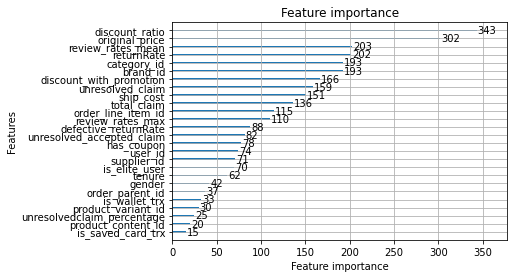

In [45]:
plot_importance(model)

In [46]:
df_test = pd.read_csv("test_all.csv")
df_test.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name
0,2021-07-31 00:00:02.035000+00:00,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,259.96,...,1,0.076923,0.003652,5.000000,5,5,2020,Yargıcı,1182,Elbise
1,2021-07-31 00:00:05.503000+00:00,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,73.49,...,0,0.000000,0.002828,4.378505,1,5,15508,TRENDYOL MAN,604,T-Shirt
2,2021-07-31 00:00:08.173000+00:00,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,39.95,...,0,0.000000,0.001260,4.500000,3,5,381,Ltb,581,Deniz Şortu
3,2021-07-31 00:00:10.850000+00:00,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,64.99,...,8,0.727273,0.001929,4.071429,1,5,1027526,Meriche,597,Gömlek
4,2021-07-31 00:00:10.989000+00:00,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,59.49,...,47,0.238579,0.002970,3.941176,1,5,36426,Güneşkızı,604,T-Shirt


In [48]:
df_test = df_test.merge(df_user, on="user_id", how="left")

In [49]:
df_test.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,brand_id,brand_name,category_id,category_name,discount_ratio,discount_with_promotion,has_coupon,used_promo,gender,tenure
0,2021-07-31 00:00:02.035000+00:00,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,259.96,...,2020,Yargıcı,1182,Elbise,0.399945,0.00,0,0,Bayan,3845
1,2021-07-31 00:00:05.503000+00:00,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,73.49,...,15508,TRENDYOL MAN,604,T-Shirt,0.699971,0.30,0,1,Bayan,1245
2,2021-07-31 00:00:08.173000+00:00,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,39.95,...,381,Ltb,581,Deniz Şortu,0.500000,0.00,0,0,Bayan,1846
3,2021-07-31 00:00:10.850000+00:00,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,64.99,...,1027526,Meriche,597,Gömlek,0.541628,0.40,0,1,UNKNOWN,479
4,2021-07-31 00:00:10.989000+00:00,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,59.49,...,36426,Güneşkızı,604,T-Shirt,0.562447,0.25,0,1,Bayan,3680


In [47]:
df_test["is_saved_card_trx"] = df_test["is_saved_card_trx"].replace({True: 1, False: 0})
df_test["discount_ratio"] = df_test["discounted_price"] / df_test["original_price"]
df_test["discount_with_promotion"] = ((df_test["coupon_discount"] * -1) + (df_test["promotion_award_value"])).fillna(0) / 100
df_test["has_coupon"] = df_test["coupon_id"].notna().astype(int)
df_test["used_promo"] = df_test["promotion_name"].notna().astype(int)

KeyError: 'gender'

In [52]:
df_test["gender"] = df_test["gender"].replace({"Bayan": 1, "Bay": 0, "UNKNOWN": -1, "kvkktalepsilindi": -2})

In [54]:
drop_cols = ["order_date", "coupon_id", "promotion_name", "discounted_price", 
             "promotion_award_value", "coupon_discount", "brand_name", "category_name"]

df_test.drop(drop_cols, axis=1, inplace=True)
df_test.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,review_rates_min,review_rates_max,brand_id,category_id,discount_ratio,discount_with_promotion,has_coupon,used_promo,gender,tenure
0,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,8.88,0,...,5,5,2020,1182,0.399945,0.00,0,0,1,3845
1,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,9.40,1,...,1,5,15508,604,0.699971,0.30,0,1,1,1245
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,10.67,0,...,3,5,381,581,0.500000,0.00,0,0,1,1846
3,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,11.33,0,...,1,5,1027526,597,0.541628,0.40,0,1,-1,479
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,8.88,0,...,1,5,36426,604,0.562447,0.25,0,1,1,3680


In [55]:
test_preds = model.predict(df_test[X_train.columns])

In [56]:
df_test["id"] = df_test.apply(lambda x: str(x.user_id) + "|" + str(x.product_content_id) + "|" + str(x.order_parent_id), axis=1)

In [57]:
df_test["expected"] = test_preds
df_test.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,brand_id,category_id,discount_ratio,discount_with_promotion,has_coupon,used_promo,gender,tenure,id,expected
0,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,8.88,0,...,2020,1182,0.399945,0.00,0,0,1,3845,5323264.0|55264030.0|721367415.0,1.0
1,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,9.40,1,...,15508,604,0.699971,0.30,0,1,1,1245,18238989.0|4032918.0|721367451.0,0.0
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,10.67,0,...,381,581,0.500000,0.00,0,0,1,1846,13354100.0|98066435.0|721367483.0,1.0
3,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,11.33,0,...,1027526,597,0.541628,0.40,0,1,-1,479,49613268.0|87599480.0|721367533.0,0.0
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,8.88,0,...,36426,604,0.562447,0.25,0,1,1,3680,7252871.0|96509590.0|721367537.0,0.0


In [58]:
df_test = df_test.groupby(by=["user_id" , "product_content_id" , "order_parent_id"])["expected"].max().reset_index()

In [59]:
df_test

,user_id,product_content_id,order_parent_id,expected
0,2141,80306720,726403811,0.0
1,2472,74477923,728406577,0.0
2,6888,110023460,726725509,0.0
3,6888,122717581,726725509,0.0
4,6888,126934595,726725509,0.0
...,...,...,...,...
469905,71173209,39088676,722304223,0.0
469906,71173209,74591958,722304223,0.0
469907,71173209,75798504,722304223,0.0
469908,71173209,81125378,722304223,0.0


In [60]:
sub_data = pd.read_csv("data/test_data.csv")
sub_data
#id: user_id | product_content_id | order_parent_id

,id,expected
0,18115|87073974|726348863,NaN
1,27588|118753298|723169934,NaN
2,29165|35699988|724122443,NaN
3,29969|5893187|722342150,NaN
4,35107|93897418|723421057,NaN
...,...,...
7466,71083899|100019570|728638514,NaN
7467,71106534|35624085|725372928,NaN
7468,71115350|94438742|725291348,NaN
7469,71115350|100017676|725291348,NaN


In [61]:
sub_data[["user_id" , "product_content_id" , "order_parent_id"]] = sub_data["id"].str.split("|", expand=True)
sub_data.head()

,id,expected,user_id,product_content_id,order_parent_id
0,18115|87073974|726348863,NaN,18115,87073974,726348863
1,27588|118753298|723169934,NaN,27588,118753298,723169934
2,29165|35699988|724122443,NaN,29165,35699988,724122443
3,29969|5893187|722342150,NaN,29969,5893187,722342150
4,35107|93897418|723421057,NaN,35107,93897418,723421057


In [62]:
sub_data = sub_data[["user_id" , "product_content_id" , "order_parent_id"]].astype(int)

In [63]:
sub_data

,user_id,product_content_id,order_parent_id
0,18115,87073974,726348863
1,27588,118753298,723169934
2,29165,35699988,724122443
3,29969,5893187,722342150
4,35107,93897418,723421057
...,...,...,...
7466,71083899,100019570,728638514
7467,71106534,35624085,725372928
7468,71115350,94438742,725291348
7469,71115350,100017676,725291348


In [64]:
sub_final = sub_data.merge(df_test, on=["user_id" , "product_content_id" , "order_parent_id"], how="left")
sub_final.head()

,user_id,product_content_id,order_parent_id,expected
0,18115,87073974,726348863,1.0
1,27588,118753298,723169934,1.0
2,29165,35699988,724122443,0.0
3,29969,5893187,722342150,1.0
4,35107,93897418,723421057,0.0


In [65]:
sub_final.expected = sub_final.expected.astype(int)

In [66]:
sub_final["id"] = sub_final.apply(lambda x: str(x.user_id) + "|" + str(x.product_content_id) + "|" + str(x.order_parent_id), axis=1)

In [67]:
sub_final.head()

,user_id,product_content_id,order_parent_id,expected,id
0,18115,87073974,726348863,1,18115|87073974|726348863
1,27588,118753298,723169934,1,27588|118753298|723169934
2,29165,35699988,724122443,0,29165|35699988|724122443
3,29969,5893187,722342150,1,29969|5893187|722342150
4,35107,93897418,723421057,0,35107|93897418|723421057


In [68]:
sub_final.expected.value_counts(normalize=True)

0    0.761879
1    0.238121
Name: expected, dtype: float64

In [69]:
sub_final[["id", "expected"]].to_csv("sub_file_110422.csv", index=False)

### Roc curve and AUC

In [70]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [71]:
ns_probs = [0 for _ in range(len(y_val))]
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, preds)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.854


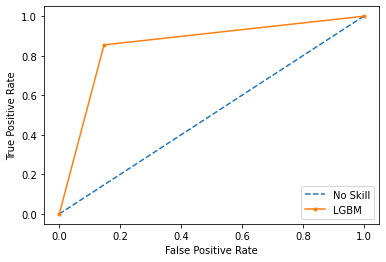

In [72]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()